In [1]:
import os
import numpy as np
import pandas as pd
from typing import List, Any
import matplotlib.pyplot as plt
from dotenv import load_dotenv
from sqlalchemy.engine import Engine
from sqlalchemy import create_engine
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

base_path = "/media/bruno/Arquivos/Desenvolvimento/DataScienceSalaries"
load_dotenv(f"{base_path}/config/.env")

True

In [2]:
def get_engine() -> Engine:
    user = os.getenv("DB_USER")
    pw = os.getenv("DB_PASS")
    db = os.getenv("DB_NAME")
    host = os.getenv("DB_HOST")
    port = os.getenv("DB_PORT")
    return create_engine(f"mysql+pymysql://{user}:{pw}@{host}:{port}/{db}")

In [3]:
def group_job(df: pd.DataFrame) -> pd.DataFrame:
    job_group = {
        "Data Scientist": ["Data Scientist", "Data Science Consultant", "Principal Data Scientist", "Applied Data Scientist", "Applied Machine Learning Scientist", "Machine Learning Developer", "Data Specialist", "Staff Data Scientist"],

        "Data Engineer": ["Data Engineer", "Machine Learning Engineer", "Analytics Engineer", "Data Analytics Engineer", "Data Science Engineer", "Machine Learning Infrastructure Engineer", "Principal Data Engineer", "ETL Developer", "Cloud Data Engineer", "NLP Engineer", "Big Data Engineer", "Computer Vision Engineer", "ML Engineer", "Computer Vision Software Engineer"],

        "Data Analyst": ["Data Analyst", "BI Data Analyst", "Business Data Analyst", "Principal Data Analyst", "Financial Data Analyst", "Product Data Analyst", "Marketing Data Analyst", "Finance Data Analyst"],

        "Research Scientist": ["Research Scientist", "Machine Learning Scientist", "AI Scientist", "3D Computer Vision Researcher"],

        "Data Lead": ["Lead Data Engineer", "Head of Data Science", "Lead Data Scientist", "Lead Data Analyst", "Lead Machine Learning Engineer", "Head of Machine Learning", "Data Analytics Lead"],

        "Data Manager": ["Data Science Manager", "Director of Data Science", "Data Analytics Manager", "Head of Data", "Data Engineering Manager", "Director of Data Engineering",  "Machine Learning Manager"],

        "Data Architect": ["Data Architect", "Big Data Architect"]
    }

    convert = []
    for i in range(0, len(df)):
        value = df["job_title"].values[i]
        for group in job_group.keys():
            if value in job_group[group]:
                value = group
                break
        convert.append(value)
    df["job_title"] = convert
    return df

In [4]:
class Model:
    def __init__(self, models: List[LinearRegression]) -> None:
        self.__models = models

    def predict(self, x: Any) -> List[float]:
        results= []
        for model in self.__models:
            results.append(list(model.predict(x)))
        results = np.array(results)
        return [np.mean(results[:, i]) for i in range(0, len(x))]


O modelo final apresenta delta entre teste e treino de 366323032.7411909 (8%)
O erro médio foi de 77.02%


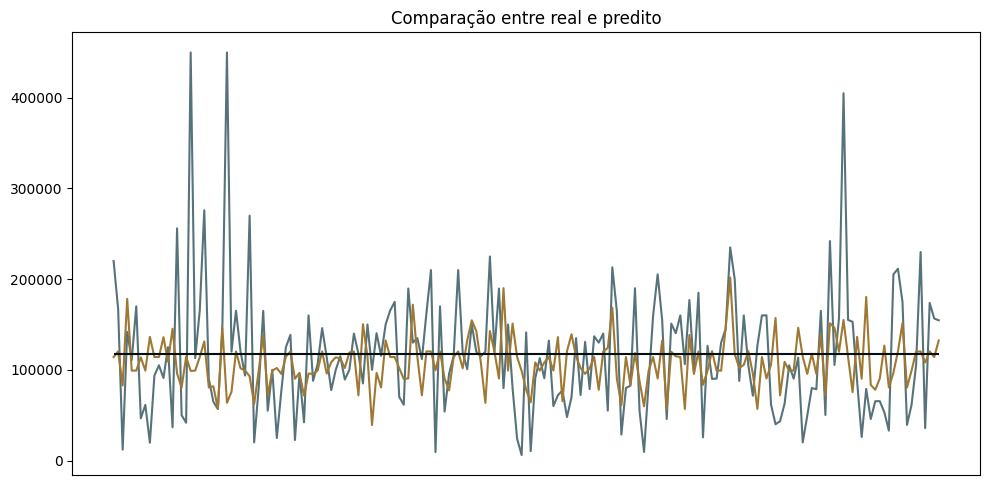

In [26]:
engine = get_engine()
with engine.connect() as con:
    query = """
        select
            s.remote_ratio,
            case
                when s.experience_level = 'Júnior' then 1
                when s.experience_level = 'Pleno' then 2
                when s.experience_level = 'Sênior' then 3
                when s.experience_level = 'Especialista' then 4
            end as experience_level,
            case
                when s.employment_type = 'Full-time' then 4
                when s.employment_type = 'Contrato' then 3
                when s.employment_type = 'Meio período' then 2
                when s.employment_type = 'Freelancer' then 1
            end as employment_type,
            case
                when s.company_size = 'Pequena' then 1
                when s.company_size = 'Média' then 2
                when s.company_size = 'Grande' then 3
            end as company_size,
            s.job_title,
            s.salary_usd
        from kaggle.ds_salaries s
    """
    dataset = pd.read_sql(query, con)
    dataset = group_job(dataset)
    
    X, y = dataset.values[:, :-1], dataset.values[:, -1]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

    encoder = OneHotEncoder()
    transform_train = encoder.fit_transform(X_train[:, -1:]).toarray()
    transform_test = encoder.transform(X_test[:, -1:]).toarray()

    X_train = np.concatenate((np.delete(X_train, -1, 1), transform_train), axis=1)
    X_test = np.concatenate((np.delete(X_test, -1, 1), transform_test), axis=1)

    models = []
    quantity = 10
    for i in range(0, quantity):
        regressor = LinearRegression()
        X_sample, y_sample = [], []

        while len(X_sample) < len(X_train):
            j = np.random.randint(0, len(X_train))
            X_sample.append(X_train[j])
            y_sample.append(y_train[j])

        regressor.fit(X_sample, y_sample)
        models.append(regressor)

    model = Model(models)
    y_pred_test = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    error = [abs(y_pred_test[i] - y_test[i]) * 100 / y_test[i] for i in range(0, len(y_test))]

    score_train = mean_squared_error(y_train, y_pred_train)
    score_test = mean_squared_error(y_test, regressor.predict(X_test))
    delta = score_test - score_train

    print(f"\nO modelo final apresenta delta entre teste e treino de {delta} ({round(delta * 100 / score_train)}%)")
    print(f"O erro médio foi de {round(np.mean(error), 2)}%")

    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    axis = [i for i in range(0, len(y_test))]
    ax.plot(axis, y_test, label="Real", color="#57737A")
    ax.plot(axis, y_pred_test, label="Previsão", color="#9F7833")
    ax.hlines(np.mean(y_test), min(axis), max(axis), label="Média", color="#040F0F")
    ax.set_title("Comparação entre real e predito")
    ax.set_xticks([])

    plt.tight_layout()
    plt.show()